# Stack Overflow: Tag Prediction 

## 1. Business Problem

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### 1.1 Sources and Refernces: 

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data 

Youtube : https://youtu.be/nNDqbUhtIRg 

Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf 

Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

### 1.2 Business Constraints:

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

## 2. Machine Learning Problem:

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />

__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

# 3. Exploratory Data Analysis:

## 3.1 Data Loading and Cleaning

### 3.1.1 Using Pandas with SQLite to Load the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shamimio","key":"e57ea3117a95a3194da0e8aaa7da68b7"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#changeb the permmission
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c facebook-recruiting-iii-keyword-extraction

100% 2.18G/2.19G [00:33<00:00, 61.9MB/s]
100% 2.19G/2.19G [00:33<00:00, 69.5MB/s]
100% 722M/725M [00:12<00:00, 51.7MB/s]
100% 725M/725M [00:12<00:00, 58.8MB/s]
 98% 77.0M/78.7M [00:01<00:00, 47.9MB/s]
100% 78.7M/78.7M [00:01<00:00, 67.6MB/s]


In [4]:
from zipfile import ZipFile
file_name = "Train.zip"

with ZipFile(file_name, 'r') as zip_file:
  zip_file.extractall()
  print("Done")

Done


In [5]:
pip install scikit-multilearn

    100% |████████████████████████████████| 92kB 7.2MB/s 


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j=0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [3]:
#Creating a new database with 500k Points
if not os.path.isfile('data_new.db'):
    con = sqlite3.connect('train.db')
    disk_dup = create_engine("sqlite:///data_new.db")
    #no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    
    new = pd.read_sql_query('SELECT * FROM data LIMIT 500001', con)

    new.to_sql('data_new',disk_dup)
    con.close()

In [4]:
# Cointing number of rows

if os.path.isfile('data_new.db'):
    start = datetime.now()
    con = sqlite3.connect('data_new.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data_new""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")
    
    

Number of rows in the database : 
 500001
Time taken to count the number of rows : 0:00:08.165739


### 3.1.2 Checking for duplicates 

In [10]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('data_new.db'):
    start = datetime.now()
    con = sqlite3.connect('data_new.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data_new GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:06.500339


In [11]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2


In [12]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 14164 ( 2.832794334411326 % )


In [13]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    471819
2     13872
3       146
Name: cnt_dup, dtype: int64

In [14]:
#adding a new feature number of tags per question

start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text:len(text.split(" ")))
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.393995


,Title,Body,Tags,cnt_dup,tag_count
0,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,php forms,1,2
1,"$f$ a continuous function in [0,1], Show: $\l...","<p>Let $f$ be a continuous function in [0,1] a...",calculus,1,1
2,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1,3
3,500 Internal Server Error in ASP.NET MVC,<p>I am working in ASP.NET MVC. I am using par...,asp.net-mvc,1,1
4,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,2,2


In [15]:
# number of tags per qurstion
df_no_dup.tag_count.value_counts()

3    139065
2    129207
4     93550
1     66624
5     57391
Name: tag_count, dtype: int64

In [5]:
# creating a new datbse with no duplicates

if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns = ['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [6]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:07.836965


# 3.2 Analysis of Tags

## 3.2.1 Total number of unique tags 

In [7]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [8]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 485836
Number of unique tags : 30429


In [9]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.exe', '.hgtags']


### 3.2.3 Number of times a tag appeared 

In [15]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [10]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,3
1,.app,8
2,.aspxauth,3
3,.bash-profile,13
4,.class-file,5


In [73]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

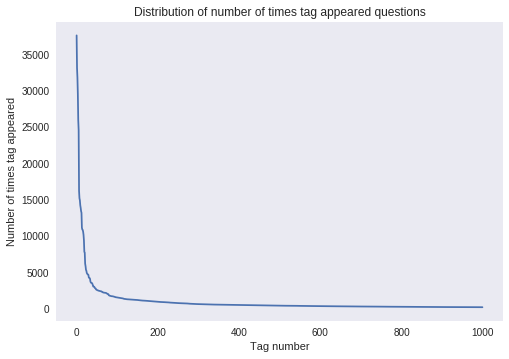

In [24]:
plt.plot(tag_counts[:1000])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

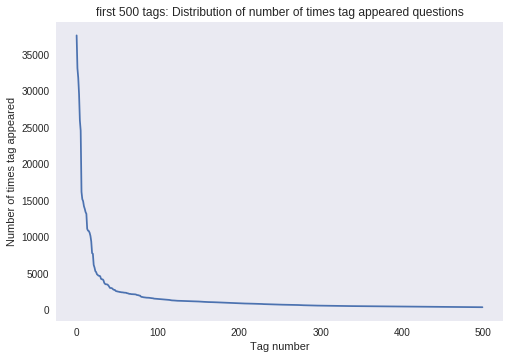

100 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576  1529  1480  1429  1370
  1315  1279  1257  1234  1215  1199  1178  1138  1109  1092  1072  1055
  1030   998   981   949   924   910   900   881   865   854   822   802
   790   769   747   739   725   716   701   686   664   646   636   620
   612   602   594   591   577   573   562   555   548   541   539   534
   525   514   506   502   496   494   487   484   479   475   470   462
   457   453   447   447   441   438   434   429   427   421   419   416
   407   404   402   400]


In [25]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

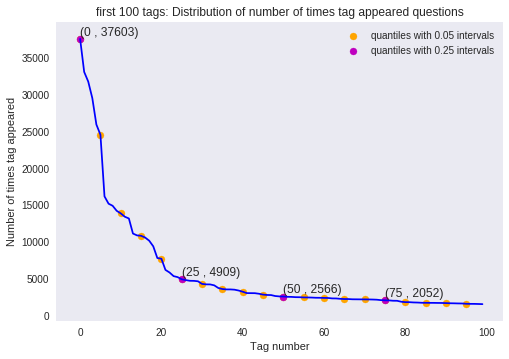

20 [37603 24567 13873 10826  7706  4909  4279  3585  3221  2827  2566  2442
  2376  2222  2176  2052  1801  1708  1670  1576]


In [26]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [11]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>5000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

25 Tags are used more than 10000 times
18 Tags are used more than 100000 times


### 3.2.4 Tags Per Question

In [13]:
# Storing the count of tag in each question in the list 'tag_count
tag_quest_count = tag_dtm.sum(axis=1).tolist()

# converting list of lists into single list,we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print('We have total {} datapoints.'.format(len(tag_quest_count)))
print(tag_quest_count[:5])

We have total 485836 datapoints.
[1, 3, 1, 2, 4]


In [14]:
print ("Maximum no of tag per question: %d"%max(tag_quest_count))
print ("Minimum no of tags per quest: %d"%min(tag_quest_count))
print ("Avg number of tags per qudestion: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum no of tag per question: 5
Minimum no of tags per quest: 1
Avg number of tags per qudestion: 2.888600


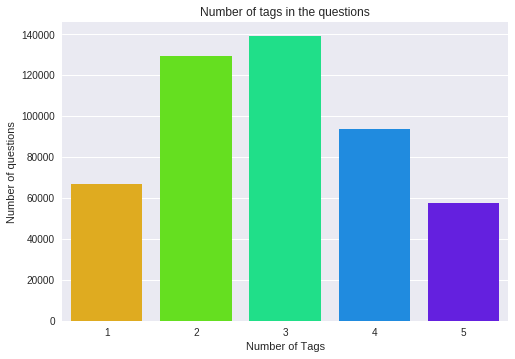

In [30]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### 3.2.5 Most Frequent Tags 

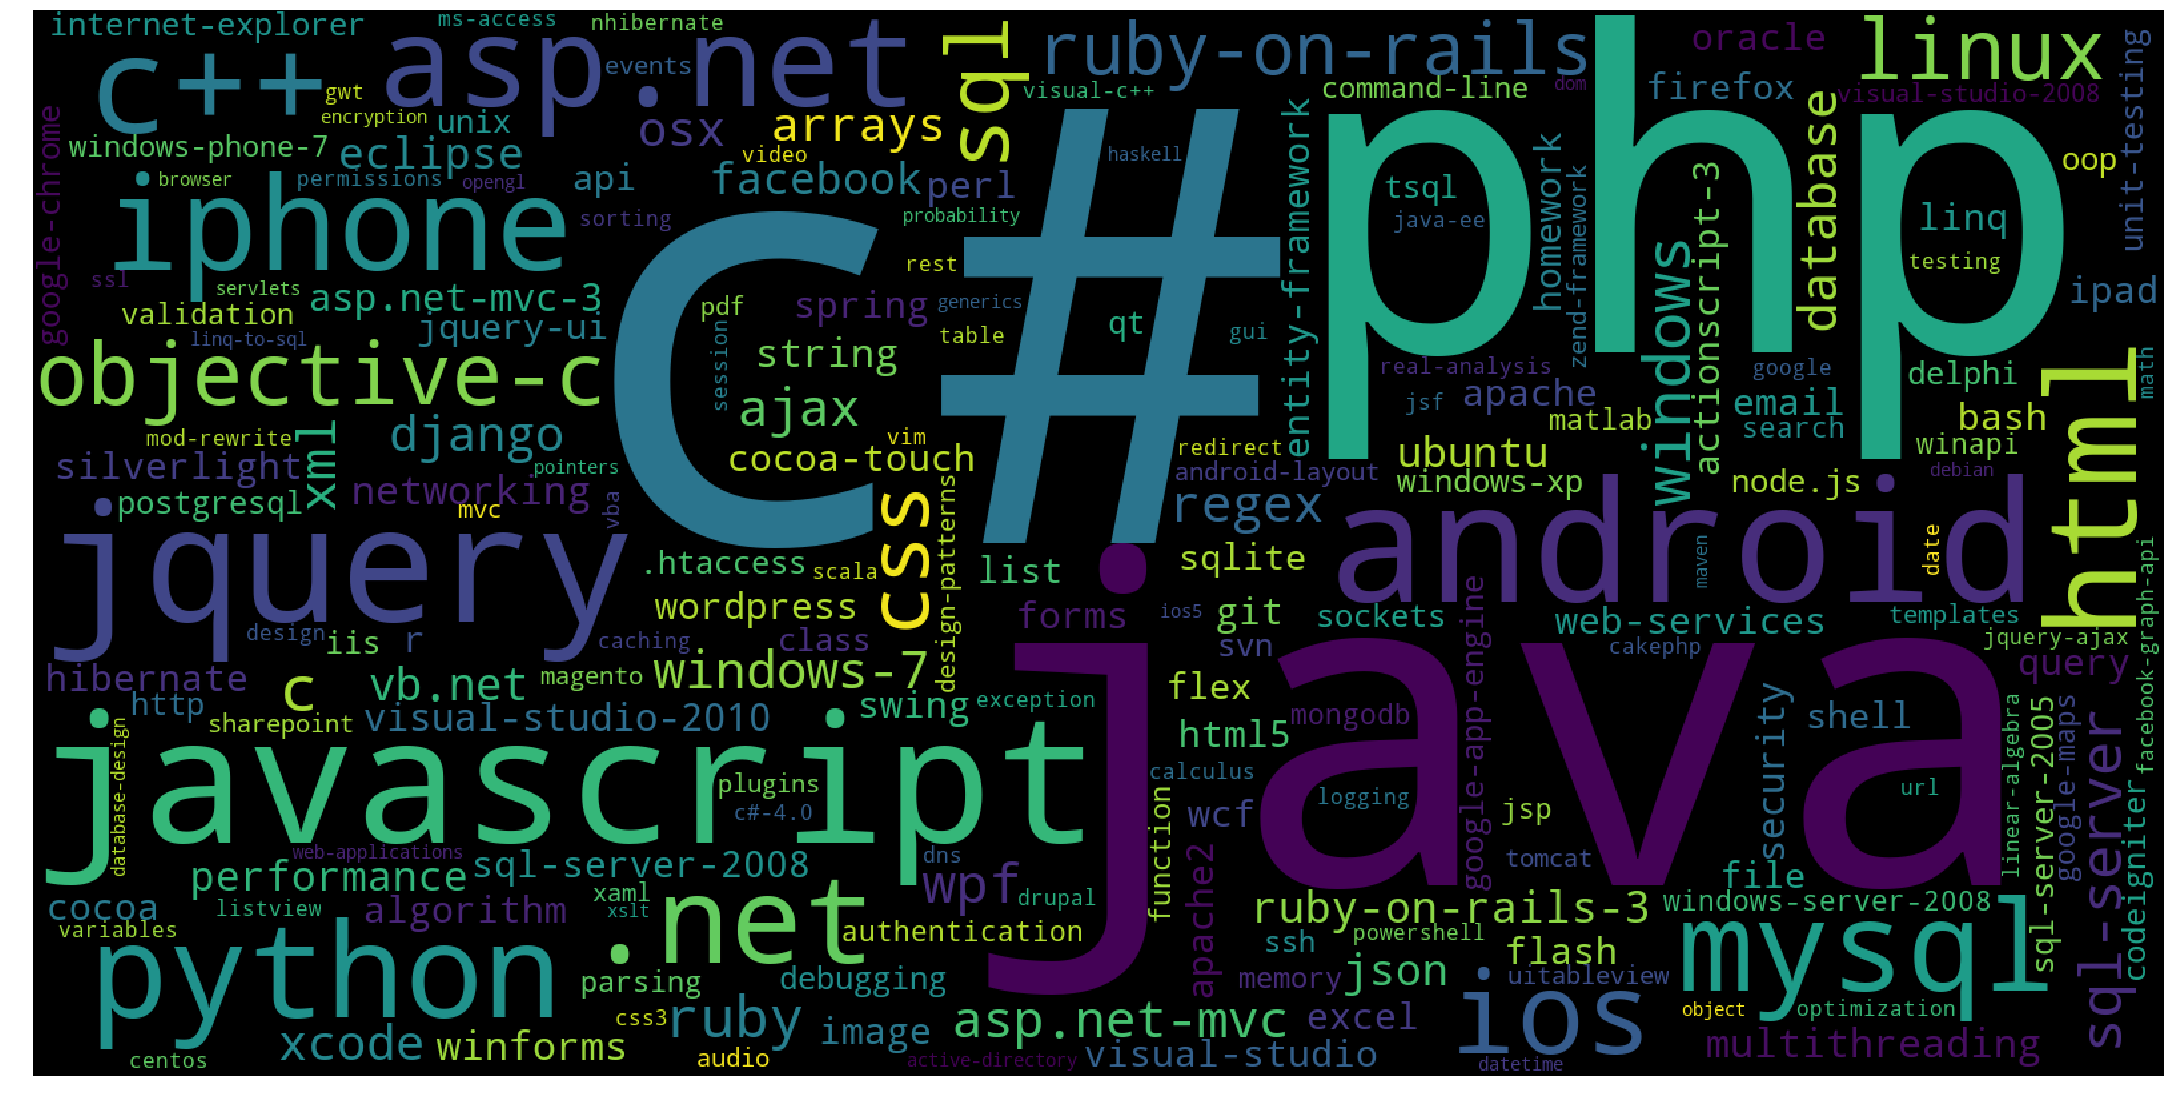

Time taken to run this cell : 0:00:06.151975


In [16]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### 3.2.6 The top 20 tags

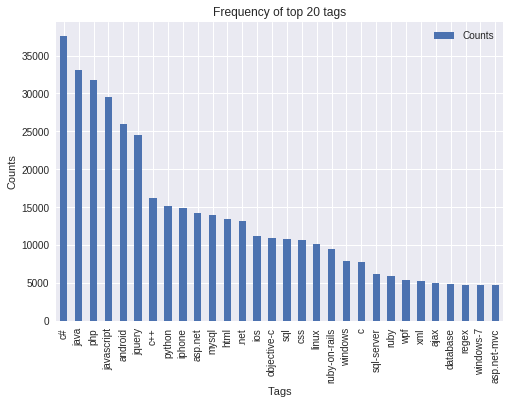

In [32]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

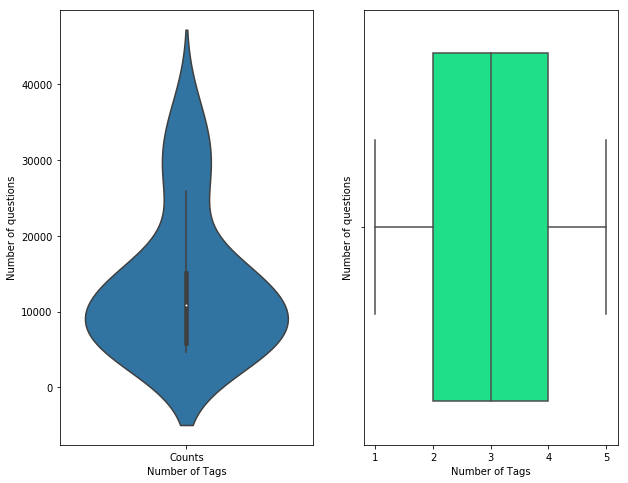

In [96]:
# Obsetving the quantiles using the violin plot and box .

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(data = tag_df_sorted.head(30) , )
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")

plt.subplot(1,2,2)
sns.boxplot(tag_quest_count, palette='gist_rainbow')
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observation: Most of the tags are acquired by 10000 questions and has 3 tags. 

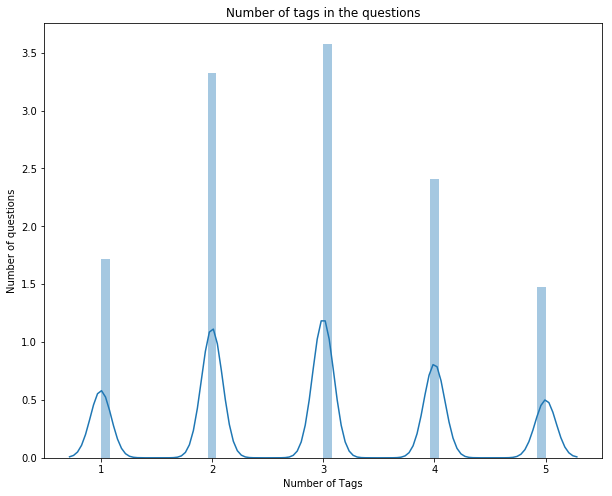

In [84]:
# plot for average no of tags per question 

plt.figure(figsize=(10, 8))
plt.subplot()
sns.distplot(tag_quest_count)
plt.title("Number of tags in the questions")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

Observation: Most of the questions have 3 tags in average and there is an average of 10000 questions with 3 tags, 5000 questions with 1 tag and so on.

## 3.3 Cleaning and preprocessing of Questions

### 3.3.1 Preprocessing

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()


In [4]:
sql_create_table = """CREATE TABLE IF NOT EXISsql_create_tableTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [5]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM();")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:52.538222


### Preprocessing of questions:

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1150
Avg. length of questions(Title+Body) after processing: 410
Percent of questions containing code: 56
Time taken to run this cell : 0:21:47.817606


In [7]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

#### Sample quesitons after preprocessing of data

In [8]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('loos object git gui refer loos object git gui refer loos object git gui refer open git gui get popup messag refer loos object git gc remov messag loos object could prevent occur',)
----------------------------------------------------------------------------------------------------
('solv system equat unknown equat solv system equat unknown equat solv system equat unknown equat solv system equat first-year physic told abl find solut system unknown one exist need least equat system look known quantiti theta theta cos theta mg sin theta frac ell sin theta cos theta mg sin theta frac ell sin theta system equat unknown quantiti ell abl success solv four equat logic error understand',)
----------------------------------------------------------------------------------------------------
('audio clip loop continu audio clip loop continu audio clip loop continu anyon point right direct code play audio clip continu play stop',)
--------------------------------------

#### Saving Preprocessed data to a Database

In [9]:
# taking the data to tghe dataframe
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [10]:
preprocessed_data.head()

,question,tags
0,select employe hql select employe hql select e...,hibernate hql
1,loos object git gui refer loos object git gui ...,git
2,solv system equat unknown equat solv system eq...,algebra-precalculus
3,audio clip loop continu audio clip loop contin...,java javasound
4,linqpad system.net trace linqpad system.net tr...,httpwebrequest linqpad tracing system.net


In [11]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 485836
number of dimensions : 2


<h1>Converting tags for multilabel problems</h1>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

#### Converting string Tags to multilable output variables :

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [13]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

<b> Selecting 500 Tags</b>

In [14]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
        questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

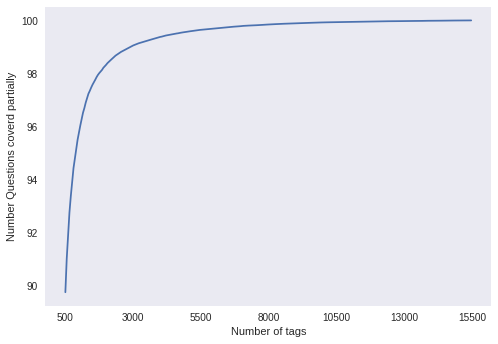

with  5500 tags we are covering  99.056 % of questions
with  500 tags we are covering  89.747 % of questions


In [48]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [15]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 49812 out of  485836


In [16]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preproctrain_datasizeessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [17]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (85836, 500)


In [18]:
from sklearn.externals import joblib
joblib.dump(x_train, 'x_train_1.pkl') 

joblib.dump(x_test, 'x_test_1.pkl')

joblib.dump(y_train, 'y_train_1.pkl')

joblib.dump(y_test, 'y_test_1.pkl')

['y_test_1.pkl']

<h2>Featurization:</h2>

In [19]:
x_train=joblib.load( 'x_train_1.pkl')
x_test=joblib.load( 'x_test_1.pkl')

y_train=joblib.load( 'y_train_1.pkl')

y_test=joblib.load('y_test_1.pkl')

In [20]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=40000, tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:39.780679


In [21]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 40000) Y : (400000, 500)
Dimensions of test data X: (85836, 40000) Y: (85836, 500)


### Applying Logistic Regression with OneVsRest Classifier

In [29]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

model_to_set = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))

parameters = {
    "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)

0.4466043958066712
{'estimator__alpha': 0.0001}


In [31]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.14983223822172514
Hamming loss  0.003888252015471364
Micro-average quality numbers
Precision: 0.4552, Recall: 0.4537, F1-measure: 0.4545
Macro-average quality numbers
Precision: 0.3705, Recall: 0.3692, F1-measure: 0.3638
              precision    recall  f1-score   support

           0       0.48      0.42      0.45      6820
           1       0.57      0.56      0.57      5931
           2       0.66      0.61      0.63      5555
           3       0.57      0.52      0.54      5232
           4       0.79      0.82      0.80      4612
           5       0.70      0.70      0.70      4352
           6       0.61      0.62      0.61      2870
           7       0.69      0.72      0.70      2636
           8       0.53      0.51      0.52      2710
           9       0.54      0.53      0.53      2508
          10       0.64      0.69      0.66      2416
          11       0.34      0.26      0.29      2384
          12       0.27      0.25      0.26      2355
         

# Linear SVM :- 

In [22]:
from sklearn.model_selection import GridSearchCV

model_to_set = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))

parameters = {
    "estimator__alpha": [10**-5, 10**-3, 10**-2, 10**1]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='f1_micro',n_jobs=-1)

model_tunning.fit(x_train_multilabel, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)

0.43896966470627347
{'estimator__alpha': 0.001}


In [23]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.19328719884430776
Hamming loss  0.003178945896826506
Micro-average quality numbers
Precision: 0.5944, Recall: 0.3438, F1-measure: 0.4356
Macro-average quality numbers
Precision: 0.3550, Recall: 0.2444, F1-measure: 0.2739
             precision    recall  f1-score   support

          0       0.56      0.24      0.33      6489
          1       0.71      0.43      0.53      5898
          2       0.79      0.55      0.65      5527
          3       0.66      0.42      0.51      5212
          4       0.83      0.75      0.79      4600
          5       0.84      0.63      0.72      4380
          6       0.74      0.50      0.60      2910
          7       0.82      0.64      0.72      2737
          8       0.62      0.44      0.52      2665
          9       0.69      0.44      0.54      2540
         10       0.78      0.64      0.70      2448
         11       0.43      0.16      0.24      2321
         12       0.37      0.19      0.25      2244
         13       0.59 

In [27]:
from prettytable import PrettyTable
ptable = PrettyTable()

ptable.title = " Comparison of Performances "
ptable.field_names = ['Model','Hyperparameter', 'Macro Train F1-Score ','Macro Test F1-Score']
ptable.add_row(["Logistic Regression","0.0001","0.45", "0.36"])
ptable.add_row(["Linear SVM", "0.001", "0.43", "0.27"])

print(ptable)

+---------------------+----------------+-----------------------+---------------------+
|        Model        | Hyperparameter | Macro Train F1-Score  | Macro Test F1-Score |
+---------------------+----------------+-----------------------+---------------------+
| Logistic Regression |     0.0001     |          0.45         |         0.36        |
|      Linear SVM     |     0.001      |          0.43         |         0.27        |
+---------------------+----------------+-----------------------+---------------------+


## Observations: 

<h3>EDA:</h3>

a. We have observed that there are total of 485836 tags present in our 500k data out of which 30429 are unique.

b. When we quantiled the tags we observed that 25 tags appeared 10000 times and 18 tags appeared more than      100000 times which is dramatic.

c. We observed that in each question there is an average of 3 tags.

d. The most common tags are C#, JAVA, php etc

e. And the most common tag C# apperaed more than 35000 times.

f. We have selected 500 most common tags which constitutes 89.47% question and further proceeded our operation.

<h3>Model Fabrication:</h3>

a. Logistic Regression: We build logistic regression model using SGDClassifier with log loss and we got macro f1-score as 0.36.

b. Linear SVM: We built the Linear SVM model using SGDClassifier with hinge loss and got a macro f1-score as 0.27

### Few of the steps followed:

In [ ]:
1. After EDA i have selected top 500 features as they constitutes 89 % of the question and also due to computation power.
2. Next we have done hyperparameter tuning using grid search and SGDclassifier with log loss.
3. We had to train models for each of our tags so used one vs rest classifier with our grid search and got our best hyperparameter.   
4. Then i trained my logistic regression model and got macro f1-score of 0.36.
5. Similarly we trained our linear SVM model and got macro f1-score of 0.27.
6. We observe that our Linear SVM model performs better in this case.
7. I have added extra EDA on cell[96] and cell[84] which demonstrates most number of questions and average number of tags per question. 